# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_aws langchain_core langgraph --trusted-host pypi.org --trusted-host files.pythonhosted.org
%pip install --upgrade python-dotenv --trusted-host pypi.org --trusted-host files.pythonhosted.org

In [2]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../.env")

os.environ["AWS_ACCESS_KEY_ID"] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv('AWS_SECRET_ACCESS_KEY')
os.environ["AWS_DEFAULT_REGION"] =os.getenv('AWS_DEFAULT_REGION')

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation.

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Vijay"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Vijay"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Vijay

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Vijay

I want to learn about the best place to see Orcas in the US.


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [4]:
from langchain_aws import ChatBedrock
# --- Chat Model ---
llm = ChatBedrock(
    model_id="mistral.mistral-7b-instruct-v0:2",
    temperature=1,
)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [5]:
result

AIMessage(content=" Orcas, also known as killer whales, can be found in various locations in the United States. One of the best places to see them is in the Pacific Northwest, specifically in the waters around the San Juan Islands in Washington State. The San Juan Islands are located in the Salish Sea, which is a rich and productive marine ecosystem that provides ample food sources for Orcas. The San Juan Islands are home to several pods of Orcas, including the Southern Resident Killer Whale pods, which are well known for their close interactions with boats and are considered one of the most accessible populations of Orcas in the world.\n\nAnother place to see Orcas in the US is in Monterey Bay, California. Monterey Bay is a hotspot for marine life, and Orcas are known to frequent the area, especially during the summer months. The best way to see them in Monterey Bay is by taking a boat tour.\n\nAdditionally, Alaska is another great destination to see Orcas, especially in the waters ar

In [6]:
result.response_metadata

{'usage': {'prompt_tokens': 62,
  'completion_tokens': 341,
  'cache_read_input_tokens': 0,
  'cache_write_input_tokens': 0,
  'total_tokens': 403},
 'stop_reason': None,
 'thinking': {},
 'model_id': 'mistral.mistral-7b-instruct-v0:2',
 'model_name': 'mistral.mistral-7b-instruct-v0:2'}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple.

You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!

The `multiply` function is our tool.

In [7]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned.

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [13]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Vijay")])

In [25]:
tool_call

AIMessage(content=' The product of multiplying the number 2 by the number 3 is 6. In mathematical terms, you can write this as: 2 * 3 = 6. This is a basic multiplication operation. Multiplying a number by itself or by another number results in the total amount of that number being combined together a certain number of times. In this case, you have 2 groups of 3, which totals to 6 groups or 6 items.', additional_kwargs={'usage': {'prompt_tokens': 17, 'completion_tokens': 99, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 116}, 'stop_reason': None, 'thinking': {}, 'model_id': 'mistral.mistral-7b-instruct-v0:2', 'model_name': 'mistral.mistral-7b-instruct-v0:2'}, response_metadata={'usage': {'prompt_tokens': 17, 'completion_tokens': 99, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 116}, 'stop_reason': None, 'thinking': {}, 'model_id': 'mistral.mistral-7b-instruct-v0:2', 'model_name': 'mistral.mistral-7b-instruct-v0:2'}, id='run-

Tool calls are optionally invoked by the model, so we can also see the model's response.


In [26]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"Hello", name="Vijay")])

In [27]:
tool_call

AIMessage(content=" Hello! How can I help you today? If you have any questions or need assistance with something, feel free to ask. I'm here to help. If you just want to chat or share some thoughts, that's fine too. Let me know what's on your mind. :)", additional_kwargs={'usage': {'prompt_tokens': 9, 'completion_tokens': 61, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 70}, 'stop_reason': None, 'thinking': {}, 'model_id': 'mistral.mistral-7b-instruct-v0:2', 'model_name': 'mistral.mistral-7b-instruct-v0:2'}, response_metadata={'usage': {'prompt_tokens': 9, 'completion_tokens': 61, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 70}, 'stop_reason': None, 'thinking': {}, 'model_id': 'mistral.mistral-7b-instruct-v0:2', 'model_name': 'mistral.mistral-7b-instruct-v0:2'}, id='run--fbf675f8-2992-4064-b413-694e14a7a221-0', usage_metadata={'input_tokens': 9, 'output_tokens': 61, 'total_tokens': 70, 'input_token_details': {'cache_creat

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [28]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem!

As we discussed, each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.

As our graph runs, we want to **append** messages to our `messages` state key.

We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.

But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [29]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)!

`MessagesState` is defined:

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [30]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [31]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Vijay")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='b4a2ce1f-04e8-445d-9b07-7f775f714f32'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Vijay', id='3db718ed-ed44-4e67-b725-db103d22e8a6'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='4e3ffd7c-ae4e-4e7c-85f2-7322bab71369')]

## Our graph

Now, lets use `MessagesState` with a graph.

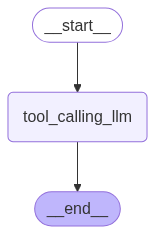

In [32]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [33]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

 Hello! How can I help you today? I'm here to answer any questions you might have, or to help you find information on a wide range of topics. So feel free to ask me anything!

For example, I can help with math problems, explain concepts in science or history, provide definitions of words or phrases, give recommendations for books, movies, or music, and much more. Just let me know what you're looking for, and I'll do my best to help you out!

If you have a specific question or topic in mind, go ahead and ask me now. If not, I can suggest some interesting and educational topics for you to explore. Let me know what you'd prefer!

Here are a few ideas to get you started:

* What's the difference between a battery and a fuel cell?
* How do volcanoes form and erupt?
* What's the theory behind the game of chess?
* What are s

The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [34]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

 The product of multiplying the numbers 2 and 3 is 6.
